In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np
import os
import math
import cv2
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, jaccard_score, classification_report

In [2]:
!pip install pkbar
import pkbar

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
batch_size = 8
device = 'cuda'
num_classes= 3
input_shape=(3,224,224)

learning_rate = 1e-3
num_epochs = 50

In [5]:
main = 'drive/My Drive/Liver Cancer Subtype Classification'
dataset = 'drive/My Drive/TCGA_train_test_val'

train_dir = os.path.join(dataset, 'Training')
val_dir = os.path.join(dataset, 'Validation')
test_dir = os.path.join(dataset, 'Testing')

check_pt_file = os.path.join(main, 'pnet3_tcga_atonce_1e-3_40.pth.tar')

In [6]:
my_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()
    ])
train_dataset = datasets.ImageFolder(train_dir, transform=my_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=transforms.ToTensor())
test_dataset = datasets.ImageFolder(test_dir, transform=transforms.ToTensor())

In [7]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

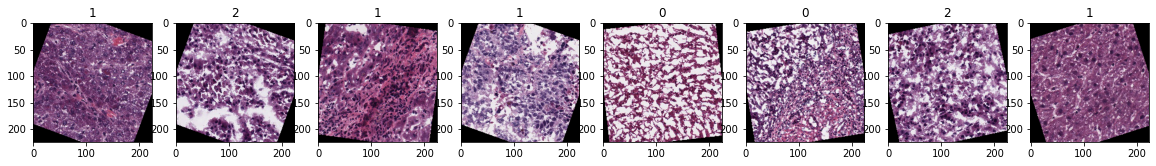

In [8]:
it = next(iter(train_loader))
images, labels= it

plt.figure(figsize=(20,15))
for r in range(batch_size):
    plt.subplot(4,8,r+1)
    f= plt.imshow(images[r].permute(2,1,0))
    plt.title(labels[r].item())
plt.show()

#Architecture

In [9]:
class Conv_Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, bias=True, mode='normal'):
        super(Conv_Block, self).__init__()

        if mode=='normal':
          self.conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias),
                                    nn.BatchNorm2d(out_channels),
                                    nn.ReLU(inplace=True))

        elif mode=='separable':
          self.conv = nn.Sequential(nn.Conv2d(in_channels, in_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=in_channels, bias=bias),
                                    nn.BatchNorm2d(in_channels),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
                                    nn.BatchNorm2d(out_channels),
                                    nn.ReLU(inplace=True))
      
    def forward(self, x):
        x = self.conv(x)
        return x

class Residual_Block(nn.Module):
  def __init__(self, in_channels, out_channels, identity_downsample = False, stride=1):
    super(Residual_Block,self).__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels//4, kernel_size=3, stride=stride, padding=1)
    self.bn1= nn.BatchNorm2d(out_channels//4)
    self.act = nn.LeakyReLU()
    self.conv2 = nn.Conv2d(out_channels//4, out_channels, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.identity_downsample = identity_downsample
    self.conv_d = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0)

  def forward(self,x):
    identity = x
    x = nn.Sequential(self.conv1,
                      self.bn1,
                      self.act,
                      self.conv2,
                      self.bn2)(x)
    if self.identity_downsample or stride!=1:
      identity = nn.Sequential(self.conv_d,
                               self.bn2)(identity)
    
    x += identity
    x = self.act(x)
    return x

class CBAM_Block(nn.Module):
  def __init__(self, in_features, reduction_ratio = 8):
    super(CBAM_Block, self).__init__()
    self.avgpool = nn.AdaptiveAvgPool2d(1)
    self.maxpool = nn.AdaptiveMaxPool2d(1)
    self.sigmoid = nn.Sigmoid()
    self.MLP = nn.Sequential(nn.Linear(in_features=in_features, out_features=in_features//reduction_ratio, bias=False),
                            nn.ReLU(),
                            nn.Linear(in_features=in_features//reduction_ratio, out_features=in_features, bias=False))
    self.conv_s = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=7, stride=1, padding=3, bias=False)
    
  def get_channel_attention(self, x):
    Fc_avg = torch.squeeze(self.avgpool(x))
    Fc_max = torch.squeeze(self.maxpool(x))
    Fc = self.sigmoid(self.MLP(Fc_avg)+self.MLP(Fc_max))
    return torch.unsqueeze(torch.unsqueeze(Fc, 2), 3)

  def get_spatial_attention(self, x):
    Fs_avg = torch.mean(x, dim=1, keepdim=True)
    Fs_max, _ = torch.max(x, dim=1, keepdim=True)
    return self.sigmoid(self.conv_s(torch.cat((Fs_avg, Fs_max), dim=1)))
  
  def forward(self, x):
    x = self.get_channel_attention(x)*x
    x = self.get_spatial_attention(x)*x
    return x

class DenseASPP_Block(nn.Module):
  def __init__(self, in_channels, in_height):
    super(DenseASPP_Block, self).__init__()

    self.conv1x1 = Conv_Block(in_channels, in_channels, kernel_size=1, padding=0, bias = False, mode='separable')
    self.conv3x3_2 = Conv_Block(in_channels, in_channels, kernel_size=3, padding=2, dilation=2, bias = False, mode='separable')
    self.conv1 = Conv_Block(2*in_channels, in_channels, kernel_size=1, padding=0, bias=False, mode='separable')
    self.conv3x3_3 = Conv_Block(in_channels, in_channels, kernel_size=3, padding=3, dilation=3, bias = False, mode='separable')
    self.conv2 = Conv_Block(3*in_channels, in_channels, kernel_size=1, padding=0, bias=False, mode='separable')
    self.conv3x3_6 = Conv_Block(in_channels, in_channels, kernel_size=3, padding=6, dilation=6, bias = False, mode='separable')
    self.conv3 = Conv_Block(4*in_channels, in_channels, kernel_size=1, padding=0, bias=False, mode='separable')
    self.conv3x3_8 = Conv_Block(in_channels, in_channels, kernel_size=3, padding=8, dilation=8, bias = False, mode='separable')
    #Global Average Pooling
    self.global_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),
                                     Conv_Block(in_channels, in_channels, kernel_size=1, padding=0, bias = False, mode='separable'),
                                     nn.UpsamplingBilinear2d(scale_factor=in_height))
    self.conv1x1_after_concat = Conv_Block(in_channels*6, in_channels, kernel_size=1, padding=0, bias = False, mode='separable')

  def forward(self, x):
    op1 = self.conv1x1(x)
    op2 = self.conv3x3_2(x)

    x2 = torch.cat([x, op2], 1)
    xt = self.conv1(x2)
    op3 = self.conv3x3_3(xt)

    x2 = torch.cat([x2, op3], 1)
    xt = self.conv2(x2)
    op4 = self.conv3x3_6(xt)

    x2 = torch.cat([x2, op4], 1)
    xt = self.conv3(x2)
    op5 = self.conv3x3_8(xt)

    op6 = self.global_pool(x)

    op = torch.cat((op1,op2,op3,op4,op5,op6), dim=1)
    op = self.conv1x1_after_concat(op)
    return op

class Classifier(nn.Module):
  def __init__(self, in_features, num_classes):
    super(Classifier, self).__init__()
    self.fc1 = nn.Sequential(nn.Linear(in_features, 256),
                             nn.BatchNorm1d(256),
                             nn.ReLU(),
                             nn.Dropout(p=0.3))
    self.fc2 = nn.Linear(256, num_classes)
    self.act = nn.Softmax(dim = -1)
  def forward(self, x):
    x = x.reshape(x.shape[0], -1)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.act(x)
    return x

#-------------------------------------------

class ProposedNet(nn.Module):
  def __init__(self, image_shape, num_classes):
    super(ProposedNet, self).__init__()
    in_height = image_shape[-1]

    self.conv_block_1 = Conv_Block(3, 32, kernel_size=3, padding=1)
    self.conv_block_2 = Conv_Block(32, 32, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.conv_block_3 = Conv_Block(32, 64, kernel_size=3, padding=1)
    self.cbam_1 = CBAM_Block(in_features=64)
    self.res_block_1 = Residual_Block(in_channels=64,
                                     out_channels=64,
                                     identity_downsample = True)
    self.conv_block_4 = Conv_Block(64, 64, kernel_size=3, padding=1)
    self.cbam_2 = CBAM_Block(in_features=64)
    self.res_block_2 = Residual_Block(in_channels=64,
                                     out_channels=64,
                                     identity_downsample = True)

    self.aspp_1 = DenseASPP_Block(in_channels = 32, in_height = in_height//2)
    self.aspp_2 = DenseASPP_Block(in_channels = 64, in_height = in_height//4)
    self.aspp_3 = DenseASPP_Block(in_channels = 64, in_height = in_height//8)
    self.upsample_1 = nn.UpsamplingBilinear2d(scale_factor=2)
    self.upsample_2 = nn.UpsamplingBilinear2d(scale_factor=4)
    self.upsample_3 = nn.UpsamplingBilinear2d(scale_factor=8)
    self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))
    self.classifier = Classifier(in_features=160, num_classes=num_classes)
  
  def forward(self, x):
    x1 = self.conv_block_1(x)
    x1 = self.conv_block_2(x1)
    x1 = self.pool(x1)

    x2 = self.conv_block_3(x1)
    x2 = self.cbam_1(x2)
    x2 = self.res_block_1(x2)
    x2 = self.pool(x2)

    x3 = self.conv_block_4(x2)
    x3 = self.cbam_2(x3)
    x3 = self.res_block_2(x3)
    x3 = self.pool(x3)

    a1 = self.aspp_1(x1)
    a1 = self.upsample_1(a1)

    a2 = self.aspp_2(x2)
    a2 = self.upsample_2(a2)

    a3 = self.aspp_3(x3)
    a3 = self.upsample_3(a3)

    out = torch.cat((a1,a2,a3), dim=1)
    out = self.global_avg_pool(out)
    out = self.classifier(out)
    return out

In [10]:
model = ProposedNet(input_shape, num_classes).to(device)
summary(model, input_size = input_shape, batch_size = batch_size, device = device)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 32, 224, 224]             896
       BatchNorm2d-2          [8, 32, 224, 224]              64
              ReLU-3          [8, 32, 224, 224]               0
        Conv_Block-4          [8, 32, 224, 224]               0
            Conv2d-5          [8, 32, 224, 224]           9,248
       BatchNorm2d-6          [8, 32, 224, 224]              64
              ReLU-7          [8, 32, 224, 224]               0
        Conv_Block-8          [8, 32, 224, 224]               0
         MaxPool2d-9          [8, 32, 112, 112]               0
           Conv2d-10          [8, 64, 112, 112]          18,496
      BatchNorm2d-11          [8, 64, 112, 112]             128
             ReLU-12          [8, 64, 112, 112]               0
       Conv_Block-13          [8, 64, 112, 112]               0
AdaptiveAvgPool2d-14              [8, 6

#Training

In [11]:
def check_accuracy(scores, targets):
  num_correct=0
  num_samples=0
  _, predictions= scores.max(1)
  num_correct += (predictions== targets).sum()
  num_samples= predictions.size(0)
  return num_correct/num_samples

def save_checkpoint(model, optimizer, file_name):
  checkpoint= {'state_dict': model.state_dict(),
               'optimizer_dict': optimizer.state_dict()}
  torch.save(checkpoint,file_name)

def load_checkpoint(model, optimizer, file_name):
  check_pt= torch.load(file_name, map_location= torch.device(device))
  model.load_state_dict(check_pt['state_dict'])
  optimizer.load_state_dict(check_pt['optimizer_dict'])
  return model, optimizer

def get_all_preds(model, loader, device=device):
    all_preds = torch.tensor([], device=device)
    all_labels = torch.tensor([], device=device)
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        scores = model(images)
        _, preds = scores.max(1)
        all_preds = torch.cat((all_preds, preds),dim=0)
        all_labels = torch.cat((all_labels, labels),dim=0)
    return all_preds, all_labels

In [12]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
Loss = nn.CrossEntropyLoss()
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8, last_epoch=-1, verbose=False)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

In [14]:
print("Training afresh to save at", check_pt_file)

Training afresh to save at drive/My Drive/Liver Cancer Subtype Classification/pnet3_tcga_atonce_1e-3_40.pth.tar


In [15]:
# train_per_epoch = len(train_loader)
# val_per_epoch = len(val_loader)
# min_loss = math.inf

# for epoch in range(num_epochs):
#   train_losses = []
#   train_accs = []
#   kbar_train = pkbar.Kbar(target = train_per_epoch, epoch = epoch, num_epochs = num_epochs)
#   model.train()
#   for batch_idx, (data, targets) in enumerate(train_loader):
#     data = data.to(device=device)
#     targets = targets.to(device=device)

#     scores = model(data)
#     train_loss = Loss(scores, targets)
#     train_losses.append(train_loss.item())
    
#     optimizer.zero_grad()
#     train_loss.backward()
#     optimizer.step()

#     train_acc = check_accuracy(scores, targets)
#     train_accs.append(train_acc.item())
#     kbar_train.update(batch_idx+1, values=[("loss", train_loss.item()), ("accuracy", train_acc.item())])
  
#   mean_train_loss = np.mean(train_losses)
#   mean_train_acc = np.mean(train_accs)
#   print()
#   val_losses = []
#   val_accs = []
#   kbar_val = pkbar.Kbar(target = val_per_epoch, epoch = epoch, num_epochs = num_epochs)
#   with torch.no_grad():
#     model.eval()
#     for batch_idx, (data, targets) in enumerate(val_loader):
#       data = data.to(device=device)
#       targets = targets.to(device=device)
    
#       scores = model(data)
#       val_loss = Loss(scores, targets)
#       val_losses.append(val_loss.item())

#       val_acc = check_accuracy(scores, targets)
#       val_accs.append(val_acc.item())
#       kbar_val.update(batch_idx+1, values=[("val_loss", val_loss.item()), ("val_accuracy", val_acc.item())])
    
#     mean_val_loss = np.mean(val_losses)
#     mean_val_acc = np.mean(val_accs)
    
#     scheduler.step(mean_val_loss)
#     if mean_val_loss < min_loss:
#       min_loss = mean_val_loss
#       print('\nImproved validation loss: {:.4f}'.format(min_loss))
#       save_checkpoint(model, optimizer, check_pt_file)
#       print('Model saved to {}'.format(check_pt_file))
#     print()

#Testing

In [16]:
pnet, _ = load_checkpoint(model, optimizer, check_pt_file)
pnet.eval()
print("Model loaded from", check_pt_file)

Model loaded from drive/My Drive/Liver Cancer Subtype Classification/pnet3_tcga_atonce_1e-3_40.pth.tar


In [17]:
tloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
with torch.no_grad():
    all_preds, all_labels = get_all_preds(pnet.to(device), tloader, device=device)

In [18]:
print('Classification Report\n {}'.format(classification_report(all_labels.cpu(), all_preds.cpu())))

Classification Report
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        25
         1.0       0.95      0.70      0.81        30
         2.0       0.65      0.94      0.77        16

    accuracy                           0.86        71
   macro avg       0.86      0.88      0.85        71
weighted avg       0.89      0.86      0.86        71



In [19]:
def res():
  print('Confusion Matrix \n {}\n'.format(confusion_matrix(all_labels.cpu(), all_preds.cpu())))
  print('Accuracy {}'.format(accuracy_score(all_labels.cpu(), all_preds.cpu())))
  print('Precision {}'.format(precision_score(all_labels.cpu(), all_preds.cpu(), average = None)))
  print('Recall {}'.format(recall_score(all_labels.cpu(), all_preds.cpu(), average=None)))
  print('F1 Score {}'.format(f1_score(all_labels.cpu(), all_preds.cpu(), average = None)))
  print('Jaccard Score {}'.format(jaccard_score(all_labels.cpu(), all_preds.cpu(), average = None)))
  print('\nWeighted Averages')
  print('Precision {}'.format(precision_score(all_labels.cpu(), all_preds.cpu(), average = 'weighted')))
  print('Recall {}'.format(recall_score(all_labels.cpu(), all_preds.cpu(), average='weighted')))
  print('F1 Score {}'.format(f1_score(all_labels.cpu(), all_preds.cpu(), average = 'weighted')))
  print('Jaccard Score {}'.format(jaccard_score(all_labels.cpu(), all_preds.cpu(), average = 'weighted')))
  print('\n', check_pt_file)
res()

Confusion Matrix 
 [[25  0  0]
 [ 1 21  8]
 [ 0  1 15]]

Accuracy 0.8591549295774648
Precision [0.96153846 0.95454545 0.65217391]
Recall [1.     0.7    0.9375]
F1 Score [0.98039216 0.80769231 0.76923077]
Jaccard Score [0.96153846 0.67741935 0.625     ]

Weighted Averages
Precision 0.8888677152608567
Recall 0.8591549295774648
F1 Score 0.8598347247891572
Jaccard Score 0.7656484814594765

 drive/My Drive/Liver Cancer Subtype Classification/pnet3_tcga_atonce_1e-3_40.pth.tar
